# ADA - Project

# Getting started

In [1]:
from pyspark import SparkContext

In [2]:
sc = SparkContext("local[*]", "ADA")
sc.defaultParallelism

8

In [3]:
data = sc.parallelize(range(100))
data.sum()

4950

If you received 4950 as a result, your spark is working well :) Good job !

# Other imports

In [4]:
import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import linear_model

import pprint
pp = pprint.PrettyPrinter(indent=4)

# Configuration

In [5]:
config = {
    "session":"progfun-002"
}

# Importing and parsing the data

### Importing Event Data

In [6]:
# Reading csv files: Create RDD () with one string entry per line in the file
rdd_problem_events = sc.textFile("data/"+config['session']+"_Problem_Events_with_Info.csv")
rdd_video_events = sc.textFile("data/"+config['session']+"_Video_Events.csv")
rdd_forum_events = sc.textFile("data/"+config['session']+"_Forum_Events.csv")

# Prints the first line (header) along with indices for each table
print("--- PROBLEM_EVENTS ---")
for idx,field in enumerate(rdd_problem_events.first().split(",")): 
    print(idx,field, end=" / ")

print("\n\n--- VIDEO_EVENTS ---")
for idx,field in enumerate(rdd_video_events.first().split(",")): 
    print(idx,field, end=" / ")

print("\n\n--- FORUM_EVENTS ---")
for idx,field in enumerate(rdd_forum_events.first().split(",")): 
    print(idx,field, end=" / ")

--- PROBLEM_EVENTS ---
0 EventID / 1 ForumUserID / 2 MaximumSubmissions / 3 AccountUserID / 4 SubmissionNumber / 5 Grade / 6 TimeStamp / 7 DataPackageID / 8 ProblemID / 9 SoftCloseTime / 10 ProblemType / 11 HardCloseTime / 12 Platform / 13 OpenTime / 14 EventType / 15 Title / 16 SessionUserID / 17 UniqueProblemID / 18 UniqueUserID / 

--- VIDEO_EVENTS ---
0 EventID / 1 ForumUserID / 2 OldTime / 3 AccountUserID / 4 CurrentTime / 5 SeekType / 6 TimeStamp / 7 DataPackageID / 8 UniqueRowID / 9 TableName / 10 VideoID / 11 Platform / 12 NewSpeed / 13 EventSource / 14 EventType / 15 SessionUserID / 16 NewTime / 17 OldSpeed / 

--- FORUM_EVENTS ---
0 EventID / 1 ForumUserID / 2 PostID / 3 AccountUserID / 4 TimeStamp / 5 DataPackageID / 6 UniqueRowID / 7 TableName / 8 Platform / 9 EventSource / 10 PostType / 11 EventType / 12 JoinID / 13 SessionUserID / 

In [7]:
# Use the filter method to remove the first line
rdd_problem_events = rdd_problem_events.filter(lambda x: not x.startswith('EventID'))
rdd_video_events = rdd_video_events.filter(lambda x: not x.startswith('EventID'))
rdd_forum_events = rdd_forum_events.filter(lambda x: not x.startswith('EventID'))

# Prints first record for each table
print(rdd_problem_events.first(),"\n") 
print(rdd_video_events.first(),"\n") 
print(rdd_forum_events.first(),"\n")

3bcd1a54ed6ddb04b4a6fb2906110a01,None,0,None,7,None,1365344171,progfun-002,7,2147483640,Video,2147483640,Coursera,32400,Problem.Check,Lecture 1.2 - Elements of Programming (14:25),c4d4e5fcd2feba9f3234ee8d852dc7b22fbc07e4,f322944718b2ee0e53292118111533c7,21f13b3f6b50a83343b57d2f1d07dbdf 

db75adce6b87e7ab79242ea0af4b82d4,None,154.696,None,154.697,None,1372391638,progfun-002,00000078c0f0685cc50a25a8d5734a88,Video_Events,33,coursera,1.0,None,Video.Play,ef64fb7b096008f7eaf8441684afdf99af9af54a,None,1.0 

f3fdb52859b2511308aee554a573194e,None,17,4108315,1376254235,progfun-002,000006c12322ca29c7013dac42ef1a6a,Forum_Events,coursera,None,Thread,Forum.Thread.View,03b1fa287de5ef57d9c8482195b5167f,None 



In [8]:
# Function to parse the string entries from previous dataset
def parse_problems(x):
    data = x.split(',')
    return {
        'Grade':float(data[5]),
        'TimeStamp':int(data[6]),
        'Date':pd.to_datetime(int(data[6]),unit='s'),
        'ProblemID':int(data[8]),
        'ProblemType':data[10],
        'EventType':data[14].split('.')[0],
        'EventSubType':data[14].split('.')[1],
        'Title':data[15],
        'SessionUserID':data[16]
    }

def parse_videos(x):
    data = x.split(',')
    return {
        'TimeStamp':int(data[6]),
        'Date':pd.to_datetime(int(data[6]),unit='s'),
        'VideoID':int(data[10]),
        'EventType':data[14].split('.')[0],
        'EventSubType':data[14].split('.')[1],
        'SessionUserID':data[15]
    }

def parse_forums(x):
    data = x.split(',')
    return {
        'AccountUserID':data[3],
        'TimeStamp':int(data[4]),
        'Date':pd.to_datetime(int(data[4]),unit='s'),
        'EventType':data[11].split('.')[0],
        'EventSubType':data[11].split('.')[1]
    }

In [9]:
# Function to filter the string entries from previous dataset
def filter_problems(x):
    data = x.split(',')
    return (
        # Some problem event are quiz inside video, we decide to not consider these
        (data[10]=='Assignment')
        # We remove IDs of assignments that have been used by the teaching staff for testing the platform
        and (not data[8] in ['1','2','3','4','5'])
        # Discard assignments with no grade
        and (not data[5] in ['None'])
    )

def filter_videos(x):
    data = x.split(',')
    return (
        # We remove video that do not belong to the MOOC lectures or ar just Setup videos
        (data[10] not in ['9','12','11','10','13','2','29','25','21','27','23'])
        # Keeps only "Play" EnventSubStype for videos (makes difference between opening the page or starting the video)
        and (data[14].split('.')[1] in ['Play','Load'])
    )

def filter_forums(x):
    data = x.split(',')
    return (
        True
    )

In [10]:
# Use the map method to have more workable data
rdd_problem_events_parsed = rdd_problem_events.filter(filter_problems).map(parse_problems)
rdd_video_events_parsed = rdd_video_events.filter(filter_videos).map(parse_videos)
rdd_forum_events_parsed = rdd_forum_events.filter(filter_forums).map(parse_forums)

# Prints the count of elements along with the first element of each table
print(rdd_problem_events_parsed.count())
print(rdd_problem_events_parsed.first(),"\n") 
print(rdd_video_events_parsed.count()) 
print(rdd_video_events_parsed.first(),"\n") 
print(rdd_forum_events_parsed.count()) 
print(rdd_forum_events_parsed.first(),"\n") 

90325
{'EventSubType': 'Check', 'Title': 'Functional Sets / Functional Sets', 'ProblemID': 6, 'SessionUserID': 'd8f79efa32a560b8a46ea2b12d9bed97c9e39b4b', 'TimeStamp': 1366220878, 'ProblemType': 'Assignment', 'Date': Timestamp('2013-04-17 17:47:58'), 'Grade': 9.32999992371, 'EventType': 'Problem'} 

1168226
{'EventSubType': 'Play', 'SessionUserID': 'ef64fb7b096008f7eaf8441684afdf99af9af54a', 'TimeStamp': 1372391638, 'Date': Timestamp('2013-06-28 03:53:58'), 'VideoID': 33, 'EventType': 'Video'} 

297650
{'EventSubType': 'Thread', 'TimeStamp': 1376254235, 'AccountUserID': '4108315', 'Date': Timestamp('2013-08-11 20:50:35'), 'EventType': 'Forum'} 



In [11]:
# Handles issue with the forum events table having 'AccountUserID' instead of 'SessionUserID'
# Using the table progfun-002_User_Hash_Mapping
rdd_user_mapping = sc.textFile("data/"+config['session']+"_User_Hash_Mapping.csv")
print(rdd_user_mapping.take(1)[0],"\n")

def f(x):
    x[1][1]['SessionUserID']=x[1][0] 
    return x[1][1]

rdd_forum_events_parsed = (rdd_user_mapping
    # removes header
    .filter(lambda x: not x.startswith("ForumUserID"))
    # maps to have the format (Key=AccountUserID,Value=SessionUserID)
    .map(lambda x:(x.split(",")[1],x.split(",")[6]))
    # join with rdd_forum_event to get format (map to have the (Key=AccountUserID,Value=(SessionUserID,EventObject)) format)
    .join(rdd_forum_events_parsed
        # map to have the (Key=AccountUserID,Value=EventObject) format
        .map(lambda x: (x['AccountUserID'],x))
    )
    # Use the function f to update EventObject with the joined SessionUserID
    .map(f)
)

print(rdd_forum_events_parsed.count())
print(rdd_forum_events_parsed.take(1)[0])

ForumUserID,AccountUserID,DataPackageID,UniqueRowID,TableName,Platform,SessionUserID 

297650
{'EventSubType': 'Thread', 'SessionUserID': '16e564ed1e9b7104acde8f075c26a1872695fb5e', 'TimeStamp': 1368130954, 'EventType': 'Forum', 'Date': Timestamp('2013-05-09 20:22:34'), 'AccountUserID': '2009208'}


In [12]:
# Concatenantes all three table into one big table
rdd_events = (rdd_problem_events_parsed
    .union(rdd_video_events_parsed)
    .union(rdd_forum_events_parsed)
)
rdd_events.persist()
print(rdd_events.count())
print(rdd_events.take(1)[0])

1556201
{'EventSubType': 'Check', 'Title': 'Functional Sets / Functional Sets', 'SessionUserID': 'd8f79efa32a560b8a46ea2b12d9bed97c9e39b4b', 'Date': Timestamp('2013-04-17 17:47:58'), 'TimeStamp': 1366220878, 'ProblemType': 'Assignment', 'Grade': 9.32999992371, 'ProblemID': 6, 'EventType': 'Problem'}


### Importing meta data
The goal is to have the table linking VideoIDs to corresponding ProblemIDs

In [13]:
assignments = sorted((rdd_problem_events_parsed
    .map(lambda x: (x['ProblemID'],x['Title']))
    .distinct()
    .collect()
),key=(lambda x: x[0]))

In [14]:
rdd_video_info = sc.textFile("data/"+config['session']+"_Video_Info.csv")
videos = sorted((rdd_video_info
    .map(lambda x: x.split(','))
    .filter(lambda x: not x[1] in ['None', 'OpenTime'] )
    .map(lambda x: (int(x[7]),x[2]))
    .collect()
),key=(lambda x: x[0]))

In [15]:
# Made by hand... so painful
LECTURES_PER_PROBLEM = {
    7: [3,4,5,6,7,8,33], # Lecture 1
    6: [35,37,39,41,43,47,49], # Lecture 2
    12: [51,53,75], # Lecture 3
    14: [71,81,85,79,87,77], # Lecture 4
    17: [109,105,115,107,103,113,111], # Lecture 6
    20: [123,117,125,121,127,119] # Lecture 7
}
LECTURES_PER_PROBLEM

{6: [35, 37, 39, 41, 43, 47, 49],
 7: [3, 4, 5, 6, 7, 8, 33],
 12: [51, 53, 75],
 14: [71, 81, 85, 79, 87, 77],
 17: [109, 105, 115, 107, 103, 113, 111],
 20: [123, 117, 125, 121, 127, 119]}

In [16]:
PROBLEM_PER_LECTURE = {}
for pb in LECTURES_PER_PROBLEM.keys():
    for lc in LECTURES_PER_PROBLEM[pb]:
        PROBLEM_PER_LECTURE[lc]=pb
print(PROBLEM_PER_LECTURE)

{51: 12, 3: 7, 4: 7, 49: 6, 6: 7, 7: 7, 8: 7, 119: 20, 77: 14, 79: 14, 43: 6, 75: 12, 85: 14, 87: 14, 39: 6, 71: 14, 111: 17, 81: 14, 5: 7, 33: 7, 35: 6, 37: 6, 103: 17, 105: 17, 107: 17, 109: 17, 47: 6, 113: 17, 53: 12, 115: 17, 117: 20, 41: 6, 121: 20, 123: 20, 125: 20, 127: 20}


# Working the data

### Grouping & Sorting

In [17]:
# uses the function groupByKey on our events with the key 'SessionStudentID'
rdd_events_by_students = (rdd_events
    .map(lambda x: (x['SessionUserID'],x))
    # Groups the list of event by student
    .groupByKey()
    # Sorts each student sequence by the timestamp
    .map(lambda x: (x[0],sorted(x[1], key=(lambda event: event['TimeStamp']))))
)
rdd_events_by_students.persist()
print("Number of students: %d" % rdd_events_by_students.count()) 

Number of students: 24626


In [18]:
# Function to have a friendly way to print the events
def eventToString(event):
    return {
        "Problem": lambda x: "(P "+str(event['ProblemID'])+")",
        "Video": lambda x: "(V "+str(event['VideoID'])+")",
        "Forum": lambda x: "(F)"
    }[event['EventType']](event)

In [19]:
TEST_STUDENTS={
    '6ea6949ca133acede360d3573f9d1168b3d70b51':'very good student',
    '3b305429f93de02637949578a5f9e23f13eb0726':'did two problems',
    '865981d5b40a693bafbadae4b1df769be03a25c3':'watched 8 videos',
    '67cdae6073d1089b695e2a615a01187586ad7ba6':'normal student',
    'fb4c81b3df430d1f0fbb8d0ca3e470ac6bf92a2f':'the very best student',
    '295b3496278626b6d337812b1882b756336fd633':'whatdup with this guy?'
}

In [20]:
# Looks at the data for a few students
for studentID,events in rdd_events_by_students.filter(lambda x: x[0] in TEST_STUDENTS.keys()).collect():
    print('\n',studentID,':',TEST_STUDENTS[studentID])
    for event in events:
        print(eventToString(event), end=" ")
    print()


 6ea6949ca133acede360d3573f9d1168b3d70b51 : very good student
(V 8) (V 3) (V 3) (V 4) (V 5) (V 5) (V 6) (V 6) (V 6) (V 6) (V 6) (V 6) (V 7) (V 7) (V 7) (V 33) (V 33) (V 33) (P 7) (V 35) (V 35) (V 35) (V 35) (V 35) (V 35) (V 35) (V 35) (V 35) (V 35) (V 35) (V 35) (V 37) (V 37) (V 37) (V 37) (V 37) (V 37) (V 37) (V 37) (V 39) (V 39) (V 39) (V 41) (V 41) (V 43) (V 47) (V 49) (P 6) (P 6) (P 6) (V 51) (V 51) (V 51) (V 53) (V 53) (V 53) (V 75) (V 75) (V 75) (V 75) (P 12) (V 79) (V 77) (V 81) (V 83) (V 85) (V 87) (V 71) (P 14) (P 14) (V 73) (V 89) (V 91) (V 93) (V 95) (V 95) (V 97) (V 101) (P 14) (P 14) (P 14) (P 14) (P 14) (P 14) (P 14) (V 103) (V 105) (V 107) (V 109) (V 111) (V 113) (V 115) (F) (F) (F) (F) (F) (F) (F) (F) (P 17) (V 109) (V 111) (V 113) (V 107) (V 117) (V 119) (V 121) (V 123) (V 125) (V 127) (V 125) (F) (F) (P 20) (F) (F) (V 125) (V 125) (P 20) (F) 

 865981d5b40a693bafbadae4b1df769be03a25c3 : watched 8 videos
(V 8) (V 3) (V 4) (V 5) (V 6) (V 7) (V 7) (V 33) (V 35) (V 35) (

## Extracting learning patterns
The goal is to extract what a students does between a failed attempt at an assignment and a successful attempt

In [21]:
# The goal is to extract the list corresponding to each Problem
def extractPatterns(events):
    patterns = {}
    for problemID in LECTURES_PER_PROBLEM.keys():
        patterns[problemID]=[]
    # for each problem measure first and last entry
    for event in events:
        if event['EventType']=='Problem':
            patterns[event['ProblemID']].append(event)
        if event['EventType']=='Video':
            if event['VideoID'] in PROBLEM_PER_LECTURE.keys():
                patterns[PROBLEM_PER_LECTURE[event['VideoID']]].append(event)
    return patterns
    

In [22]:
# The goal is to concatenate small sub events into one big event
# For example Play/Pause/Play/Pause/Play/Pause on a video counts as only a Video event
def eventConcat(events):
    if len(events)<2:
        return events
    res=[events[0]]
    for event in events[1:]:
        if (
            event['EventType']!=res[-1]['EventType'] 
            or event.get('VideoID',None)!=res[-1].get('VideoID',None)
            or event['EventType']=='Problem'
        ):
            res.append(event)
    return res

def patternsConcat(patterns):
    res = {}
    for pattern in patterns.keys():
        res[pattern]=eventConcat(patterns[pattern])
    return res

In [23]:
rdd_events_by_students_extract = (rdd_events_by_students
    # x = (studentID,eventList)
    .map(lambda x: (x[0],extractPatterns(x[1])))
    # x = (studentID,{problemID:pattern,...})
    .map(lambda x: (x[0],patternsConcat(x[1])))
)

rdd_events_by_students_extract.persist()

# Looks at the data for a student, now that it's sorted by TimeStamps
def displayStudentsPatterns(rdd,students):
    for studentID,patterns in rdd.filter(lambda x:x[0] in students.keys()).collect():
        print(studentID, students[studentID])
        for pb in sorted(patterns.keys()):
            print(pb,end='\t>>>  ')
            for event in patterns[pb]:
                print(eventToString(event), end=" ")
            print()
        print()

displayStudentsPatterns(rdd_events_by_students_extract,TEST_STUDENTS)

6ea6949ca133acede360d3573f9d1168b3d70b51 very good student
6	>>>  (V 35) (V 37) (V 39) (V 41) (V 43) (V 47) (V 49) (P 6) (P 6) (P 6) 
7	>>>  (V 8) (V 3) (V 4) (V 5) (V 6) (V 7) (V 33) (P 7) 
12	>>>  (V 51) (V 53) (V 75) (P 12) 
14	>>>  (V 79) (V 77) (V 81) (V 85) (V 87) (V 71) (P 14) (P 14) (P 14) (P 14) (P 14) (P 14) (P 14) (P 14) (P 14) 
17	>>>  (V 103) (V 105) (V 107) (V 109) (V 111) (V 113) (V 115) (P 17) (V 109) (V 111) (V 113) (V 107) 
20	>>>  (V 117) (V 119) (V 121) (V 123) (V 125) (V 127) (V 125) (P 20) (V 125) (P 20) 

865981d5b40a693bafbadae4b1df769be03a25c3 watched 8 videos
6	>>>  (V 35) 
7	>>>  (V 8) (V 3) (V 4) (V 5) (V 6) (V 7) (V 33) 
12	>>>  
14	>>>  
17	>>>  
20	>>>  

3b305429f93de02637949578a5f9e23f13eb0726 did two problems
6	>>>  (P 6) 
7	>>>  (P 7) 
12	>>>  
14	>>>  
17	>>>  
20	>>>  

fb4c81b3df430d1f0fbb8d0ca3e470ac6bf92a2f the very best student
6	>>>  (V 35) (V 37) (V 39) (V 41) (V 43) (V 47) (V 49) (P 6) (P 6) 
7	>>>  (V 8) (V 3) (V 4) (V 5) (V 4) (V 6) (V 7) (

In [24]:
def eventToString(event,verbosity):
    if verbosity == 'minimal':
        out = {
            "Problem": lambda x:"P",
            "Video": lambda x:"V",
            "Forum": lambda x:"F",
        }
    if verbosity == 'normal':
        out = {
            "Problem": lambda x:"P"+str(x['ProblemID']),
            "Video": lambda x:"V"+str(x['VideoID']),
            "Forum": lambda x:"F",
        }
    if verbosity == 'dates':
        out = {
            "Problem": lambda x:"P"+str(x['ProblemID'])+"."+str(x['Date']),
            "Video": lambda x:"V"+str(x['VideoID'])+"."+str(x['Date']),
            "Forum": lambda x:"F"+"."+str(x['Date']),
        }
    return out[event['EventType']](event)

def patternToString(pattern,verbosity):
    link = "" if verbosity == 'minimal' else "-" if verbosity == 'normal' else '\n-> '
    return link.join([eventToString(event,verbosity) for event in pattern])

def containsProblem(pattern):
    return 'P' in patternToString(pattern,'minimal')

def getFirstProblem(pattern):
    indexOfFirstProblem = patternToString(pattern,'minimal').find('P')
    return pattern[indexOfFirstProblem]

def getLastProblem(pattern):
    return pattern[-1]

def getBeforeLastProblem(pattern):
    indexOfLastProblem = patternToString(pattern,'minimal').rfind('P')
    return pattern[:(indexOfLastProblem+1)]

def getBeforeFirstProblem(pattern):
    indexOfFirstProblem = patternToString(pattern,'minimal').find('P')
    return pattern[:indexOfFirstProblem]

def getAfterFirstProblem(pattern):
    indexOfFirstProblem = patternToString(pattern,'minimal').find('P')
    return pattern[indexOfFirstProblem:]

# Uses the method flatMap on the students patterns table to have a table of all the patterns
rdd_patterns = (rdd_events_by_students_extract
    # x = (studentID,{problemID:pattern,...})
    .flatMap(lambda x: [
        (pb,x[1][pb]) for pb in x[1].keys() 
    ])
    # x = (problemID,pattern)
    .filter(lambda x: containsProblem(x[1]))
    # x = (problemID,pattern)
    .map(lambda x: (x[0],getBeforeLastProblem(x[1])))
)

rdd_patterns.persist()
for pattern in rdd_patterns.map(lambda x: patternToString(x[1],'minimal')).take(10):
    print (pattern)

VVVVVVVVVVVP
VVVVVVVP
VVVP
VVVVP
VVVVPP
PP
P
VVVVP
VVVVVVVP
VVVVVVVP


In [25]:
def getFeatures(problem, pattern):
    features = {}
    
    videoBeforeFirstProblem = [video['VideoID'] for video in getBeforeFirstProblem(pattern)]
    value = 0. if False in [(videoID in videoBeforeFirstProblem) for videoID in LECTURES_PER_PROBLEM[problem]] else 1. 
    features['watchedAllVideosBeforeFirstProblem'] = value

    value = 1. if len(videoBeforeFirstProblem) != len(set(videoBeforeFirstProblem)) else 0.
    features['repeatedVideoBeforeFirstProblem'] = value

    value = sum([event['EventType']=='Video' for event in pattern])
    features['totalNumberOfVideoWatched'] = value

    value = sum([event['EventType']=='Problem' for event in pattern])
    features['totalNumberOfProblemSubmissions'] = value 
            
    value = 1. if [v for v in getAfterFirstProblem(pattern) if v['EventType']=='Video'] else 0.
    features['watchedSomeVideoAfterFirstProblem'] = value

    firstProblem = getFirstProblem(pattern)
    value = 1. if pattern[-1]['Grade'] > firstProblem['Grade'] else 0.
    features['increaseGradeFromFirstToLastProblem'] = value

    value = sum([event['EventType']=='Problem' for event in pattern])/len(pattern)
    features['proportionOfProblemEvents'] = value
    
    value = firstProblem['TimeStamp'] - pattern[0]['TimeStamp']
    features['timeBetweenStartAndFirstProblem'] = value / (3600*24)
    
    value = pattern[-1]['TimeStamp'] - pattern[0]['TimeStamp']
    features['timeBetweenStartAndLastProblem'] = value / (3600*24)
    
    value = pattern[-1]['TimeStamp'] - firstProblem['TimeStamp']
    features['timeBetweenFirstAndLastProblem'] = value / (3600*24)
    
    value = firstProblem['Grade']
    features['firstProblemGrade'] = value
    
    value = pattern[-1]['Grade']
    features['lastProblemGrade'] = value
    
    value = max(0,(pattern[-1]['Grade']-firstProblem['Grade']))/(10.00001-firstProblem['Grade'])
    features['percentageImprovedBetweenFirstAndLastProblem'] = value
        
    return(features)

rdd_pattern_features = (rdd_patterns
    # x = (problemID, pattern)
    .map(lambda x: (
        x[0],
        patternToString(x[1],'dates'),
        getFeatures(x[0], x[1])
    ))
)
rdd_pattern_features.persist()

FEATURES = list(rdd_pattern_features.first()[2].keys())

for featureVector in rdd_pattern_features.take(1):
    print('problem', featureVector[0])
    print('pattern\n->', featureVector[1])
    pp.pprint(featureVector[2])
    print()

problem 6
pattern
-> V35.2013-04-04 11:47:32
-> V37.2013-04-04 12:42:22
-> V39.2013-04-04 14:09:38
-> V41.2013-04-04 14:21:10
-> V43.2013-04-04 14:22:07
-> V35.2013-04-14 12:20:06
-> V41.2013-04-14 12:22:23
-> V43.2013-04-14 12:22:59
-> V47.2013-04-14 13:01:38
-> V49.2013-04-14 13:20:42
-> V37.2013-04-14 13:23:53
-> P6.2013-04-14 14:07:01
{   'firstProblemGrade': 10.0,
    'increaseGradeFromFirstToLastProblem': 0.0,
    'lastProblemGrade': 10.0,
    'percentageImprovedBetweenFirstAndLastProblem': 0.0,
    'proportionOfProblemEvents': 0.08333333333333333,
    'repeatedVideoBeforeFirstProblem': 1.0,
    'timeBetweenFirstAndLastProblem': 0.0,
    'timeBetweenStartAndFirstProblem': 10.096863425925926,
    'timeBetweenStartAndLastProblem': 10.096863425925926,
    'totalNumberOfProblemSubmissions': 1,
    'totalNumberOfVideoWatched': 11,
    'watchedAllVideosBeforeFirstProblem': 1.0,
    'watchedSomeVideoAfterFirstProblem': 0.0}



# Kmeans

In [26]:
FEATURE_AVG = {}
FEATURE_STD = {} 
for feature in FEATURES:
    stats = rdd_pattern_features.map(lambda x: x[2][feature]).stats()
    FEATURE_AVG[feature] = stats.mean()
    FEATURE_STD[feature] = stats.stdev()

dataKmeans = (rdd_pattern_features
    .map(lambda x: [(x[2][feature]-FEATURE_AVG[feature])/FEATURE_STD[feature] for feature in FEATURES])
).collect()

print(dataKmeans[0])

[0.57339547330719731, -1.0298316959137428, -0.15740134243788759, -0.19339454657896588, 0.93613054971757703, 1.0474144588658745, -0.61534729292975288, 1.5898575698892656, 1.6753566591013342, 1.2526212075538932, -0.85687127190791879, -0.81814816798094547, 0.34657299305285455]


In [27]:
print('running Kmeans algorithm')
print('\n___________________\n')

kmeansModel = KMeans(n_clusters=3)
kmeansModel.fit(dataKmeans)

centers = kmeansModel.cluster_centers_
labels = kmeansModel.labels_

print('student repartition')
for index in range(len(centers)):
    print(sum([label==index for label in labels])/len(labels),end='\t')
print('\n___________________\n')

for index in range(len(FEATURES)):
    feature = FEATURES[index]
    print(feature)
    for center in centers:
        print((center[index]*FEATURE_STD[feature])+FEATURE_AVG[feature],end='\t')
    print('\n') 


print('\n___________________\n')

running Kmeans algorithm

___________________

student repartition
0.373723249027	0.297685635538	0.328591115435	
___________________

firstProblemGrade
9.57172460079	7.99785366556	8.86725044962	

proportionOfProblemEvents
0.157182456741	0.325644052902	0.884633912424	

timeBetweenFirstAndLastProblem
0.052065721458	1.03560482433	0.239772254924	

watchedSomeVideoAfterFirstProblem
0.00336243831011	0.115209254849	0.0014805675509	

watchedAllVideosBeforeFirstProblem
0.813872769673	0.767948281729	0.000370141887603	

timeBetweenStartAndLastProblem
5.63392995272	5.97311598963	0.765554182517	

totalNumberOfProblemSubmissions
1.07185856066	2.9288193263	1.69784083899	

totalNumberOfVideoWatched
6.82086881067	6.68635590337	0.367180752623	

repeatedVideoBeforeFirstProblem
0.38239600846	0.401905410003	0.000308451573054	

timeBetweenStartAndFirstProblem
5.58186423126	4.9375111653	0.525781927594	

increaseGradeFromFirstToLastProblem
0.00233201366667	0.99428376999	0.384762492289	

percentageImprovedBetw

# Random forest 

In [28]:
RF_FEATURES = [f for f in FEATURES if not f in [
    'lastProblemGrade',
    'percentageImprovedBetweenFirstAndLastProblem', 
    #'firstProblemGrade', 
    'increaseGradeFromFirstToLastProblem',
    ''
]]

dataRF = (rdd_pattern_features
    .filter(lambda x: x[2]['totalNumberOfProblemSubmissions']>1 and x[2]['firstProblemGrade']<10)
    .map(lambda x: [x[2][feature] for feature in RF_FEATURES])
).collect()

print(dataRF[0])

[8.67000007629, 0.3333333333333333, 0.03528935185185185, 0.0, 0.0, 0.19217592592592592, 2, 4, 1.0, 0.15688657407407408]


In [29]:
labelsRF = (rdd_pattern_features
    .filter(lambda x: x[2]['totalNumberOfProblemSubmissions']>1 and x[2]['firstProblemGrade']<10)
    .map(lambda x: x[2]['lastProblemGrade']==10.)
).collect()

print(labelsRF[:10])
print(sum(labelsRF)/len(labelsRF))

[False, True, True, True, False, True, True, True, True, True]
0.7533275791577704


In [30]:
def getSplit(data,labels,proportion):
    n = int(proportion * len(data))
    Xtrain = data[:n]
    Ytrain = labels[:n]
    Xtest = data[n:]
    Ytest = labels[n:]
    return(Xtrain,Ytrain,Xtest,Ytest)

In [31]:
parameters = [2,4,8,12,16,24,32,48,64]

In [32]:
def computeScores(predictions,y):
    measures = [ 
        (
            'TP' if (predictions[index] and y[index]) else
            'FP' if (predictions[index] and not y[index]) else 
            'TN' if (not predictions[index] and not y[index]) else 
            'FN'
        
        )
        for index in range(len(y))
    ]
    TP = sum([measure == 'TP' for measure in measures])
    FP = sum([measure == 'FP' for measure in measures])
    TN = sum([measure == 'TN' for measure in measures])
    FN = sum([measure == 'FN' for measure in measures])
    
    scores = {}
    scores['TPr'] = TP / ( TP + FN )
    scores['TNr'] = TN / ( TN + FP )
    
    scores['accuracy'] = ( TP + TN ) / ( TP + TN + FP + FN )
    
    scores['precision'] = TP / ( TP + FP )
    scores['recall'] = TP / ( TP + FN )
    
    p = scores['precision']
    r = scores['recall']
    scores['Fscore'] = 2. * p * r / ( p + r )
    
    return scores

In [33]:
trainScores = []
testScores = []
for param in parameters: 
    (Xtrain,Ytrain,Xtest,Ytest) = getSplit(dataRF,labelsRF,0.8)
    clf = RandomForestClassifier(n_estimators=param,class_weight='balanced_subsample')
    clf.fit(Xtrain,Ytrain)
    
    testScore = computeScores(clf.predict(Xtest),Ytest)
    trainScore = computeScores(clf.predict(Xtrain),Ytrain)
    
    print(testScore)
    print(computeScores([True for _ in Ytest],Ytest))
    print()
    
    trainScores.append(trainScore)
    testScores.append(testScore)

{'recall': 0.682620400837571, 'accuracy': 0.6506927095162389, 'TNr': 0.55, 'precision': 0.8271112722000725, 'TPr': 0.682620400837571, 'Fscore': 0.7479514913143231}
{'recall': 1.0, 'accuracy': 0.7592550533727004, 'TNr': 0.0, 'precision': 0.7592550533727004, 'TPr': 1.0, 'Fscore': 0.8631551768654788}

{'recall': 0.7831289261142687, 'accuracy': 0.7072450601862367, 'TNr': 0.4679245283018868, 'precision': 0.8227529855436833, 'TPr': 0.7831289261142687, 'Fscore': 0.8024521072796935}
{'recall': 1.0, 'accuracy': 0.7592550533727004, 'TNr': 0.0, 'precision': 0.7592550533727004, 'TPr': 1.0, 'Fscore': 0.8631551768654788}

{'recall': 0.8423571642237512, 'accuracy': 0.7326822620940268, 'TNr': 0.3867924528301887, 'precision': 0.812463935372187, 'TPr': 0.8423571642237512, 'Fscore': 0.827140549273021}
{'recall': 1.0, 'accuracy': 0.7592550533727004, 'TNr': 0.0, 'precision': 0.7592550533727004, 'TPr': 1.0, 'Fscore': 0.8631551768654788}

{'recall': 0.8752617409512414, 'accuracy': 0.7472178060413355, 'TNr': 

In [34]:
dfTestScores = pd.DataFrame(testScores)
dfTrainScores = pd.DataFrame(trainScores)
dfTestScores.head()

,Fscore,TNr,TPr,accuracy,precision,recall
0,0.747951,0.550000,0.682620,0.650693,0.827111,0.682620
1,0.802452,0.467925,0.783129,0.707245,0.822753,0.783129
2,0.827141,0.386792,0.842357,0.732682,0.812464,0.842357
3,0.840201,0.343396,0.875262,0.747218,0.807841,0.875262
4,0.840961,0.331132,0.879450,0.747445,0.805700,0.879450


In [35]:
feature_importances = clf.feature_importances_

for index in range(len(RF_FEATURES)):
    feature = RF_FEATURES[index]
    print(feature + (40-len(feature))*' ',feature_importances[index])


firstProblemGrade                        0.309469328604
proportionOfProblemEvents                0.0579984100747
timeBetweenFirstAndLastProblem           0.199849630282
watchedSomeVideoAfterFirstProblem        0.00887474265995
watchedAllVideosBeforeFirstProblem       0.0100717735069
timeBetweenStartAndLastProblem           0.192173876772
totalNumberOfProblemSubmissions          0.0394978990669
totalNumberOfVideoWatched                0.0447263782112
repeatedVideoBeforeFirstProblem          0.0110736113251
timeBetweenStartAndFirstProblem          0.126264349497


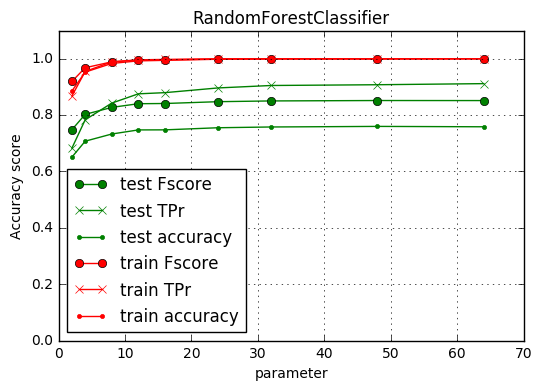

In [36]:
f, ax = plt.subplots(1)
plt.title("RandomForestClassifier")
plt.xlabel("parameter")
plt.ylabel("Accuracy score")
plt.grid()
ax.set_ylim(ymin=0,ymax=1.1)
plt.plot(parameters, dfTestScores.Fscore, 'o-', color="g", label="test Fscore")
plt.plot(parameters, dfTestScores.TPr, 'x-', color="g", label="test TPr")
plt.plot(parameters, dfTestScores.accuracy, '.-', color="g", label="test accuracy")

plt.plot(parameters, dfTrainScores.Fscore, 'o-', color="r", label="train Fscore")
plt.plot(parameters, dfTrainScores.TPr, 'x-', color="r", label="train TPr")
plt.plot(parameters, dfTrainScores.accuracy, '.-', color="r", label="train accuracy")

plt.legend(loc="best")

plt.show()

# Logistic Regression

In [37]:
LR_FEATURES = [f for f in FEATURES if not f in [
    'lastProblemGrade',
    'percentageImprovedBetweenFirstAndLastProblem', 
    #'firstProblemGrade', 
    'increaseGradeFromFirstToLastProblem',
    ''
]]

dataLR = (rdd_pattern_features
    .filter(lambda x: x[2]['totalNumberOfProblemSubmissions']>1 and x[2]['firstProblemGrade']<10)
    .map(lambda x: [(x[2][feature]-FEATURE_AVG[feature])/FEATURE_STD[feature] for feature in LR_FEATURES])
).collect()

print(dataLR[0])

[-0.10243540774469413, -0.32056816523771064, -0.1437414227373448, -0.19339454657896588, -1.0682270761291699, -0.69288238810776059, 0.12557403213126903, -0.1657018615164986, 1.6753566591013342, -0.70266894712284844]


In [38]:
labelsRF = (rdd_pattern_features
    .filter(lambda x: x[2]['totalNumberOfProblemSubmissions']>1 and x[2]['firstProblemGrade']<10)
    .map(lambda x: x[2]['lastProblemGrade']==10.)
).collect()

print(labelsRF[:10])
print(sum(labelsRF)/len(labelsRF))

[False, True, True, True, False, True, True, True, True, True]
0.7533275791577704


In [39]:
parameters = [0.0001,0.001,0.01,0.1,1,10]

In [40]:
trainScores = []
testScores = []
for param in parameters: 
    (Xtrain,Ytrain,Xtest,Ytest) = getSplit(dataRF,labelsRF,0.8)
    clf = linear_model.SGDClassifier(alpha=param, loss='log')
    clf.fit(Xtrain,Ytrain)
    
    testScore = computeScores(clf.predict(Xtest),Ytest)
    trainScore = computeScores(clf.predict(Xtrain),Ytrain)
    
    print(testScore)
    print()
    
    trainScores.append(trainScore)
    testScores.append(testScore)

{'recall': 0.7627879150463656, 'accuracy': 0.6727231433113786, 'TNr': 0.3886792452830189, 'precision': 0.797373358348968, 'TPr': 0.7627879150463656, 'Fscore': 0.7796972939917444}

{'recall': 0.9697876159138499, 'accuracy': 0.7547126958891665, 'TNr': 0.07641509433962264, 'precision': 0.7680644397062307, 'TPr': 0.9697876159138499, 'Fscore': 0.8572184029613961}

{'recall': 0.9509422674244691, 'accuracy': 0.7574381103792869, 'TNr': 0.1471698113207547, 'precision': 0.7785941709527309, 'TPr': 0.9509422674244691, 'Fscore': 0.8561809857258282}

{'recall': 0.9641040981154652, 'accuracy': 0.753577106518283, 'TNr': 0.08962264150943396, 'precision': 0.7695797516714422, 'TPr': 0.9641040981154652, 'Fscore': 0.8559288275129465}

{'recall': 0.989530361950344, 'accuracy': 0.7565296388825801, 'TNr': 0.02169811320754717, 'precision': 0.7613348676639816, 'TPr': 0.989530361950344, 'Fscore': 0.8605619146722164}

{'recall': 1.0, 'accuracy': 0.7592550533727004, 'TNr': 0.0, 'precision': 0.7592550533727004, 'TP

In [41]:
dfTestScores = pd.DataFrame(testScores)
dfTrainScores = pd.DataFrame(trainScores)
dfTestScores.head()

,Fscore,TNr,TPr,accuracy,precision,recall
0,0.779697,0.388679,0.762788,0.672723,0.797373,0.762788
1,0.857218,0.076415,0.969788,0.754713,0.768064,0.969788
2,0.856181,0.147170,0.950942,0.757438,0.778594,0.950942
3,0.855929,0.089623,0.964104,0.753577,0.769580,0.964104
4,0.860562,0.021698,0.989530,0.756530,0.761335,0.989530


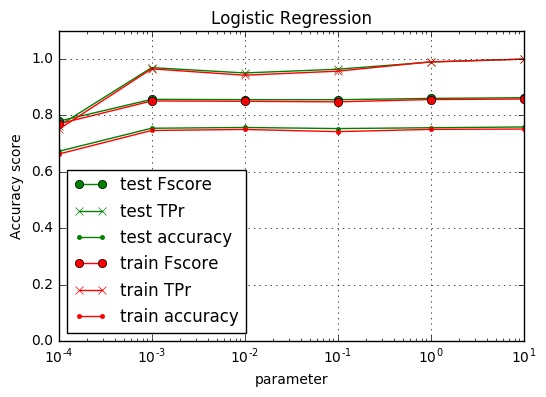

In [42]:
f, ax = plt.subplots(1)
plt.title("Logistic Regression")
plt.xlabel("parameter")
plt.ylabel("Accuracy score")
plt.grid()
ax.set_ylim(ymin=0,ymax=1.1)
plt.semilogx(parameters, dfTestScores.Fscore, 'o-', color="g", label="test Fscore")
plt.semilogx(parameters, dfTestScores.TPr, 'x-', color="g", label="test TPr")
plt.semilogx(parameters, dfTestScores.accuracy, '.-', color="g", label="test accuracy")

plt.semilogx(parameters, dfTrainScores.Fscore, 'o-', color="r", label="train Fscore")
plt.semilogx(parameters, dfTrainScores.TPr, 'x-', color="r", label="train TPr")
plt.semilogx(parameters, dfTrainScores.accuracy, '.-', color="r", label="train accuracy")

plt.legend(loc="best")

plt.show()